# 0. Import Useful Libraries and files

## 0.1 Import Useful Libraries

Please use command `pip install -r requirement.txt` to install all the libraries.

In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 0.2 Import Some Useful Functions From [TensorFlow Examples](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi)

First you need to clone the following [repository](https://github.com/tensorflow/examples/tree/master), and then change the `pose_sample_rpi_path` to the path of your cloned repository.

In [7]:
pose_sample_rpi_path = r'Your Path To Cloned Example repository/lite/examples/pose_estimation/raspberry_pi'
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
# from ml import Movenet
# movenet = Movenet('movenet_thunder')

# 1. Data Preprocessing

## 1.1 Image Scaling

Since MoveNet accepts image inputs with a resolution of $256\times 256$, we can use the function below to make the longest side of the image 256 pixels, and scale the other side proportionally, and subsequently use the padding operation to fill the image to the $256\times 256$ resolution.

In [ ]:
"""
In order to use the image scaling function below, make sure your own dataset folder is structured as follows:
Dataset
    |__bad
        |__001.jpg
        |__002.jpg
        |__......
    |__good
        |__001.jpg
        |__002.jpg
        |__......
"""

def resize_image(image_path, output_path, base=256):
    """
    Adjust the resolution of the image and then save to the target folder
    
    Args: 
        image_path: the path of the image
        Output_path: the output path of the proccessed image
        base: If the length and width of the image are not the same, the longer side is scaled to this value.
        """
    with Image.open(image_path) as img:
        # calculate the new width and length to keep the ratio
        w, h = img.size
        if w > h:
            new_w = base
            new_h = int(base * h / w)
        else:
            new_h = base
            new_w = int(base * w / h)

        # Adjust the reso and then save the image
        try:
            img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
        except AttributeError:
            img = img.resize((new_w, new_h), Image.LANCZOS)
        img.save(output_path)

def process_images(source_folder, target_folder):
    """
    Iterate over all images in the source folder and adjust their resolution
    This function will generate bad_resized and good_resized folders in the destination folder of your choice to store the resized images.
    """
    for subdir in os.listdir(source_folder):
        subdir_path = os.path.join(source_folder, subdir)
        if os.path.isdir(subdir_path):
            target_subdir = os.path.join(target_folder, subdir + '_resize')
            if not os.path.exists(target_subdir):
                os.makedirs(target_subdir)

            for image_name in os.listdir(subdir_path):
                source_path = os.path.join(subdir_path, image_name)
                target_path = os.path.join(target_subdir, image_name)

                #  Adjust image resolution and save to destination folder
                resize_image(source_path, target_path)
                print(f'Processed and saved: {target_path}')

# source folder path
source_folder = 'Your source folder path'

# target folder path
target_folder = 'Your target folder path'

process_images(source_folder, target_folder)

## 1.2 Image Padding

Use the following function to pad the image to $256\times 256$ resolution to satisfy the input required by MoveNet.

In [ ]:
def pad_image_to_square(image, fill_color=(0, 0, 0)):
    """
    Pads an image to make it square while maintaining its aspect ratio and fills the background with a specified color.

    Args:
        image (PIL.Image): The image to be padded.
        fill_color (tuple): The RGB color value used to fill the background. Default is black (0, 0, 0).

    """
    max_dim = max(image.size)
    new_img = Image.new("RGB", (max_dim, max_dim), color=fill_color)
    paste_position = ((max_dim - image.size[0]) // 2, (max_dim - image.size[1]) // 2)
    new_img.paste(image, paste_position)
    return new_img

def process_images(source_folder, target_folder):
    """
    Processes all images in the source folder by padding them to square, and saves the processed images to the target folder, maintaining the subfolder structure.

    Args:
        source_folder (str): The path to the source folder containing subfolders with images to be processed.
        target_folder (str): The path to the target folder where processed images will be saved.
    """
    for subdir in os.listdir(source_folder):
        subdir_path = os.path.join(source_folder, subdir)
        target_subdir = os.path.join(target_folder, subdir + '_padded')

        if not os.path.exists(target_subdir):
            os.makedirs(target_subdir)

        for image_name in os.listdir(subdir_path):
            source_path = os.path.join(subdir_path, image_name)
            target_path = os.path.join(target_subdir, image_name)

            if os.path.isfile(source_path): 
                try:
                    with Image.open(source_path) as img:
                        new_img = pad_image_to_square(img)
                        new_img.save(target_path)
                        print(f"Processed and saved: {target_path}")
                except IOError:
                    print(f"Cannot open or process {image_name}")

# Paths to the source and target folders
source_folder = 'Your Resized Image Path'
target_folder = 'Your Target Image Path'

# Process all images in the source folder and save them to the target folder
process_images(source_folder, target_folder)


## 1.3 Test the MoveNet

The following code can be used to detect key points of a person in an image using MoveNet and print out these key points and plot them on the image to test if the model works properly on the captured data.

Keypoint 0: x=0.5091516971588135, y=0.10809386521577835, confidence=0.6884854435920715
Keypoint 1: x=0.5267089605331421, y=0.08711856603622437, confidence=0.8464447855949402
Keypoint 2: x=0.5241021513938904, y=0.08672406524419785, confidence=0.9032333493232727
Keypoint 3: x=0.5836132168769836, y=0.108553946018219, confidence=0.7220526337623596
Keypoint 4: x=0.5804648399353027, y=0.10424188524484634, confidence=0.552766740322113
Keypoint 5: x=0.6038645505905151, y=0.22892709076404572, confidence=0.7619807124137878
Keypoint 6: x=0.5883893370628357, y=0.22290126979351044, confidence=0.6449681520462036
Keypoint 7: x=0.5518366694450378, y=0.4432715177536011, confidence=0.6634474396705627
Keypoint 8: x=0.5560176968574524, y=0.42959141731262207, confidence=0.32479003071784973
Keypoint 9: x=0.4389435052871704, y=0.47905874252319336, confidence=0.3353332579135895
Keypoint 10: x=0.4404885768890381, y=0.479471892118454, confidence=0.5346539616584778
Keypoint 11: x=0.5623623728752136, y=0.52173298

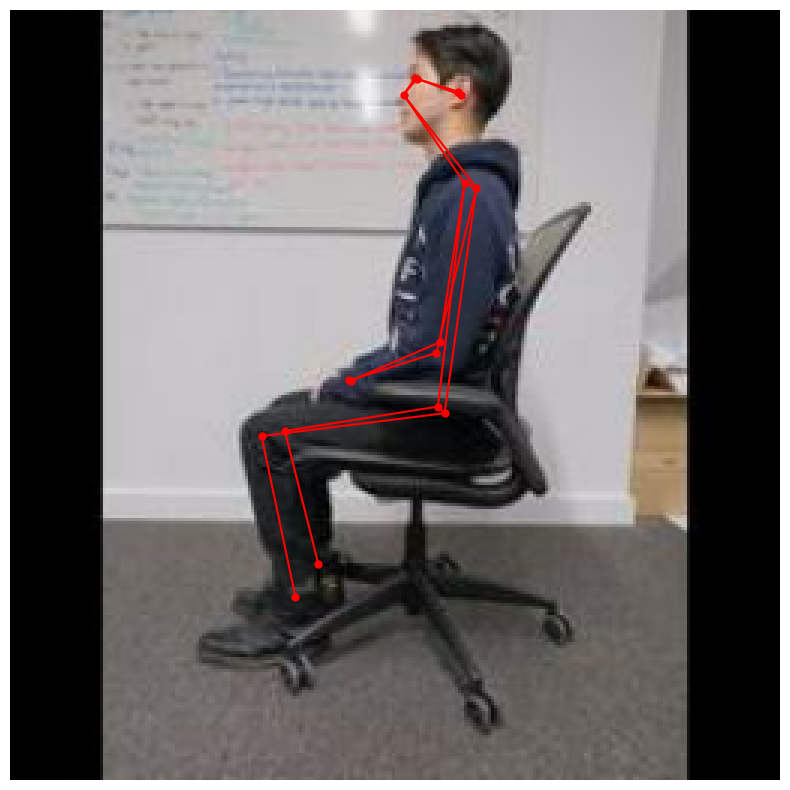

In [8]:
# Load the MoveNet Thunder model from TensorFlow Hub
model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model.signatures['serving_default']

def run_inference(image_path):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize_with_pad(image, 256, 256)
    input_image = tf.cast(image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, axis=0)

    # Run the MoveNet model
    outputs = movenet(input_image)
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores, image.numpy()

import numpy as np
import matplotlib.pyplot as plt

def draw_keypoints_and_edges(image, keypoints_with_scores):
    edges = [
        (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6),
        (5, 7), (7, 9), (6, 8), (8, 10), (5, 6), (5, 11),
        (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)
    ]

    # Extract keypoints
    keypoints = keypoints_with_scores[0, 0, :, :3]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image.astype(np.uint8))

    # Draw and print keypoints
    for idx, keypoint in enumerate(keypoints):
        y, x, confidence = keypoint
        if confidence > 0.1:
            ax.plot(x * image.shape[1], y * image.shape[0], 'ro', markersize=5)
            print(f"Keypoint {idx}: x={x}, y={y}, confidence={confidence}")

    # Draw and print edges
    for edge in edges:
        if keypoints[edge[0], 2] > 0.1 and keypoints[edge[1], 2] > 0.1:
            start_keypoint = keypoints[edge[0]]
            end_keypoint = keypoints[edge[1]]
            ax.plot(
                [start_keypoint[1] * image.shape[1], end_keypoint[1] * image.shape[1]],
                [start_keypoint[0] * image.shape[0], end_keypoint[0] * image.shape[0]],
                'r'
            )
            print(f"Edge from keypoint {edge[0]} to keypoint {edge[1]} drawn.")

    plt.axis('off')
    plt.show()


# Path to your image
image_path = 'G:/DL_Data/Data/train/good/DSCF3953.JPG'

keypoints_with_scores, image = run_inference(image_path)
draw_keypoints_and_edges(image, keypoints_with_scores)

## 1.4 Convert Image To CSV

After confirming that the image data is correct, the following code can be used to save the keypoints and confidence scores from the image data in a CSV file that can be used to train our own classification model.

In [ ]:
def run_inference(image_path):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize_with_pad(image, 256, 256)
    input_image = tf.cast(image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, axis=0)

    # Run the MoveNet model
    outputs = movenet(input_image)
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

def save_keypoints_to_csv(image_name, keypoints_with_scores, class_no, class_name, csv_writer):
    # Flatten the keypoints and scores
    keypoints = keypoints_with_scores[0, 0, :, :3].flatten()

    # Preparing the row in the specified order
    ordered_keypoints = []
    for i in range(17):  # Adjust the index according to the MoveNet output format
        ordered_keypoints.extend([keypoints[i*3], keypoints[i*3+1], keypoints[i*3+2]])

    row = [image_name] + ordered_keypoints + [class_no, class_name]
    csv_writer.writerow(row)
    print(f"Key points information for {image_name} saved successfully.")

# Path to your folder containing images
folder_path = '../DL_Data/Data/train/good/'

# Path to the output CSV file
output_csv_file = './good_train.csv'

# Open the CSV file for writing
with open(output_csv_file, mode='w', newline='') as file:
    csv_writer = csv.writer(file)
    # Write the header row in the specified order
    header = ['file_name']
    keypoints_names = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 
                       'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
                       'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
                       'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
    for name in keypoints_names:
        header.extend([f'{name}_x', f'{name}_y', f'{name}_score'])
    header.extend(['class_no', 'class_name'])
    csv_writer.writerow(header)

    print("Processing images...")

    # Iterate over all images in the folder
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        keypoints_with_scores = run_inference(image_path)
        # Here you specify the class_no and class_name for each image
        save_keypoints_to_csv(image_name, keypoints_with_scores, '1', 'good', csv_writer)

print(f"All images processed. Key points information saved to {output_csv_file}")

# 2. Load the preprocessed CSV files into `train` and `val` datasets 

In [86]:
def load_pose_landmarks(csv_path):
    """
    Loads a CSV created by MoveNetPreprocessor.

    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    classes = df_to_process.pop('class_name').unique()

    # Extract the labels
    y = df_to_process.pop('class_no')

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

X_train, y_train, class_names, _ = load_pose_landmarks('./Data/train.csv')
X_val, y_val, class_names, _ = load_pose_landmarks('./Data/val.csv')
X_test, y_test, _, df_test = load_pose_landmarks('./Data/test.csv')

# 3. Define Functions to Convert the Pose Landmarks to a Pose Embedding


Next, convert the landmark coordinates to a feature vector by:
1. Moving the pose center to the origin.
2. Scaling the pose so that the pose size becomes 1
3. Flattening these coordinates into a feature vector

Then use this feature vector to train a neural-network based pose classifier.

In [87]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

# 4. Define Classification Model

In [88]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 51)]         0           []                               
                                                                                                  
 reshape_13 (Reshape)           (None, 17, 3)        0           ['input_14[0][0]']               
                                                                                                  
 tf.__operators__.getitem_13 (S  (None, 17, 2)       0           ['reshape_13[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.compat.v1.gather_117 (TFOpL  (None, 2)           0           ['tf.__operators__.getitem

# 5. Start Training

In [89]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best_32.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
22/25 [=========================>....] - ETA: 0s - loss: 0.6838 - accuracy: 0.6278 
Epoch 1: val_accuracy improved from -inf to 0.74000, saving model to weights.best_32.hdf5
25/25 [==============================] - 2s 21ms/step - loss: 0.6826 - accuracy: 0.6413 - val_loss: 0.6631 - val_accuracy: 0.7400
Epoch 2/200
22/25 [=========================>....] - ETA: 0s - loss: 0.6588 - accuracy: 0.7259
Epoch 2: val_accuracy improved from 0.74000 to 0.88000, saving model to weights.best_32.hdf5
25/25 [==============================] - 0s 6ms/step - loss: 0.6568 - accuracy: 0.7337 - val_loss: 0.6144 - val_accuracy: 0.8800
Epoch 3/200
22/25 [=========================>....] - ETA: 0s - loss: 0.6083 - accuracy: 0.7884
Epoch 3: val_accuracy improved from 0.88000 to 0.90000, saving model to weights.best_32.hdf5
25/25 [==============================] - 0s 6ms/step - loss: 0.6025 - accuracy: 0.7950 - val_loss: 0.5350 - val_accuracy: 0.9000
Epoch 4/200
22/25 [=========================>....]

# 6. Visualise the Training Process

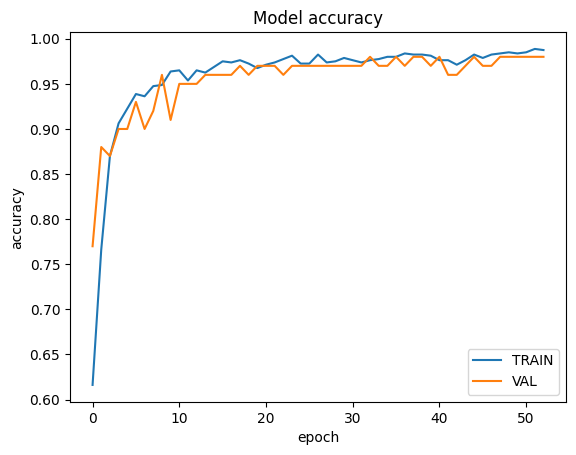

In [85]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

# 7. Evaluate the Model Using Test Data

In [80]:
loss, accuracy = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 0.5990 - accuracy: 0.7300


# 8. Convert the Model to `.tflite` Format

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpnbbebtt5\assets
Model size: 26KB


# 9. Create `.txt` File Containing Label Information

In [11]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

# 10. Evaluate the Performance of the `.tflite` Model

In [12]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.86
